In [199]:
import numpy as np
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go

from src.data.make_dataset import BCIDataset, PhysionetDataset
from src.data.signal_processing import surrogate_ts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
#Params
# data_root = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/data/raw/"
data_root = "C:/Users/annag/OneDrive/Dokumente/Special_Course/03_code/data/raw/"

#channels = [["C3","C4"],["F3","F4"],["P3","P4"]]
channels = [["CZ", "C4", "T4", "T5", "P3", "PZ", "P4", "FZ", "FP1", "FP2", "F7", "F3", "F4", "F8", "T3", "C3"]]

# Select subject for visualization
sub =  ["dani"]
# test_subjects = ["dani", "ivo", "pablo", "huiyu", "manu", "fabio", "anna", "luisa", "sarah", "irene", "jan"]

measurements = []

In [201]:
# Get dataset
trainingset = BCIDataset(data_root, sub, [], measurement_length=4)
trainingset.validate_data()
trainingset.apply_bandpass_filtering(selected_data="sample")

Subjects: ['dani']
Total invalid samples: 0


In [202]:
trainingset.data

subject               measurement      class sampleID  \
0      dani       2023-03-07_18-29-54   arm_left       10   
1      dani       2023-03-07_18-29-54   arm_left       11   
2      dani       2023-03-07_18-29-54   arm_left       12   
3      dani       2023-03-07_18-29-54   arm_left       13   
4      dani       2023-03-07_18-29-54   arm_left       15   
..      ...                       ...        ...      ...   
115    dani  2023-03-07_19-00-01_move  arm_right       38   
116    dani  2023-03-07_19-00-01_move  arm_right       39   
117    dani  2023-03-07_19-00-01_move  arm_right        3   
118    dani  2023-03-07_19-00-01_move  arm_right        5   
119    dani  2023-03-07_19-00-01_move  arm_right        9   

                            path  \
0     arm_left_10_1678210383.csv   
1     arm_left_11_1678210400.csv   
2     arm_left_12_1678210416.csv   
3     arm_left_13_1678210433.csv   
4     arm_left_15_1678210466.csv   
..                           ...   
115  arm_right_38_1678212493.csv   
116  arm_right_39_1678212505.csv   
117   arm_right_3_1678212049.csv   
118   arm_right_5_1678212074.csv   
119   arm_right_9_1678212125.csv   

                                                sample   move  \
0         Unnamed: 0     class  time_in_s        CZ...  false   
1         Unnamed: 0     class  time_in_s        CZ...  false   
2         Unnamed: 0     class  time_in_s        CZ...  false   
3         Unnamed: 0     class  time_in_s         C...  false   
4         Unnamed: 0     class  time_in_s        CZ...  false   
..                                                 ...    ...   
115       Unnamed: 0      class  time_in_s         ...   true   
116       Unnamed: 0      class  time_in_s        C...   true   
117       Unnamed: 0      class  time_in_s        C...   true   
118       Unnamed: 0      class  time_in_s        C...   true   
119       Unnamed: 0      class  time_in_s        C...   true   

                                              filtered  
0         time_in_s        CZ        C4        T4  ...  
1         time_in_s        CZ        C4        T4  ...  
2         time_in_s        CZ        C4         T4 ...  
3         time_in_s        CZ        C4         T4 ...  
4         time_in_s        CZ        C4         T4 ...  
..                                                 ...  
115       time_in_s        CZ         C4         T4...  
116       time_in_s        CZ        C4        T4  ...  
117       time_in_s        CZ        C4        T4  ...  
118       time_in_s        CZ        C4         T4 ...  
119       time_in_s        CZ        C4        T4  ...  

[120 rows x 8 columns]

In [14]:
#Load data
x, y, ch_pairs = trainingset.load_subject_data(sub[0], channels)
indexes = range(0,len(x))

#Reshape for scaling
reshaped_x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

# Train test split
train_idx, test_idx, y_train_raw, y_test = train_test_split(indexes,
                                                            y,
                                                            stratify=y,
                                                            test_size=0.20,
                                                            random_state=42)
x_train_raw = reshaped_x[train_idx]
x_test_raw = reshaped_x[test_idx]
y_train_raw = y[train_idx]
y_test = y[test_idx]
ch_pairs_train = ch_pairs[train_idx]
ch_pairs_test = ch_pairs[test_idx]

#Scale indipendently train/test
#Axis used to scale along. If 0, independently scale each feature, otherwise (if 1) scale each sample.
# x_train_scaled_raw = minmax_scale(x_train_raw, axis=1)
# x_test_scaled_raw = minmax_scale(x_test_raw, axis=1)
x_train_scaled_raw = x_train_raw
x_test_scaled_raw = x_test_raw

x_test = x_test_scaled_raw.reshape(x_test_scaled_raw.shape[0], x.shape[1], x.shape[2]).astype(np.float64)

x_train = x_train_scaled_raw.reshape(x_train_scaled_raw.shape[0], x.shape[1], x.shape[2]).astype(np.float64)
y_train = y_train_raw

Get data from subjects: ['dani']


In [15]:
print(np.shape(x))
print(np.shape(x_train))
print(np.shape(x_test))

(120, 16, 500)
(96, 16, 500)
(24, 16, 500)


In [16]:
testarr = np.swapaxes(x_train, 1,2)
print(np.shape(testarr))

(96, 500, 16)


# Create MNE Info

In [17]:
sampling_freq = trainingset.sample_rate
ch_names = ["Cz", "C4", "T4", "T5", "P3", "Pz", "P4", "Fz", "Fp1", "Fp2", "F7", "F3", "F4", "F8", "T3", "C3"]
ch_types = ['eeg'] * 16
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('standard_1020')
info['description'] = 'My recorded dataset'
print(info)

<Info | 9 non-empty values
 bads: []
 ch_names: Cz, C4, T4, T5, P3, Pz, P4, Fz, Fp1, Fp2, F7, F3, F4, F8, T3, C3
 chs: 16 EEG
 custom_ref_applied: False
 description: My recorded dataset
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 125.0 Hz
>


# Create MNE raw data

In [18]:
# Take training data
data = x_train
data_channels = ch_pairs_train
# Or take all data
# data = x
# data_channels = ch_pairs
print(np.shape(data))
print(np.shape(data_channels))

(96, 16, 500)
(96, 16)


In [19]:
# data = [num_channels x n_samples]
data_trial = data[0]
print(np.shape(data_trial))

(16, 500)


In [20]:
trial_raw = mne.io.RawArray(data_trial, info)

Creating RawArray with float64 data, n_channels=16, n_times=500
    Range : 0 ... 499 =      0.000 ...     3.992 secs
Ready.


In [21]:
selected_channels=[0,1,2]
start, stop = trial_raw.time_as_index([0.5, 3.5])  # 0.5s to 3.5s data segment
data, times = trial_raw[selected_channels, start:stop]

In [22]:
np.shape(data)

(3, 375)

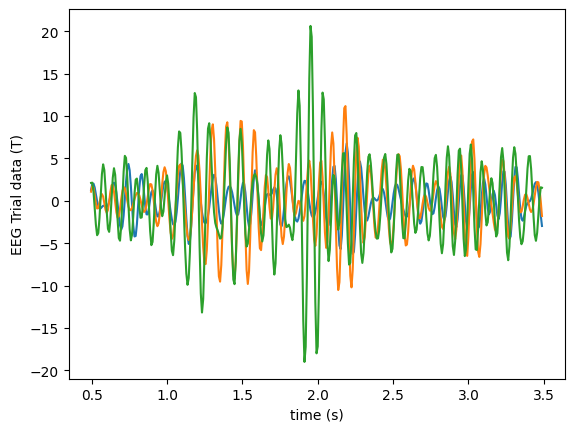

In [23]:
plt.plot(times, data.T)
plt.xlabel('time (s)')
plt.ylabel('EEG Trial data (T)')
plt.show()

In [192]:
# Resample
sampling_class_counts = {'L': 500, 'R': 500}
x = x_train
y = y_train
print(np.shape(x_train))
print(np.shape(y_train))

x_augm, y_augm = surrogate_ts(x, y, sampling_class_counts)
print(np.shape(x_augm))

(96, 16, 500)
(96,)
(1000, 16, 500)


In [198]:
np.shape(x)[1]

16

### Surrogating code:

In [193]:
FFT = np.fft.rfft(x_augm[0][0]) # FFT of time-series
Random_phases = np.exp(np.random.uniform(0,np.pi,len(x_augm[0][0])//2+1)*1.0j) # Generate random phases
FFT = FFT * Random_phases # Randomize the phases in the FFT
TS = np.fft.irfft(FFT) # Tranforms the frequency-domain back into the time-domain = Surrogate time-series

In [194]:
if len(TS) < 500:
    TS = np.append(TS, TS[-1])

In [195]:
times = np.linspace(0,4,500)

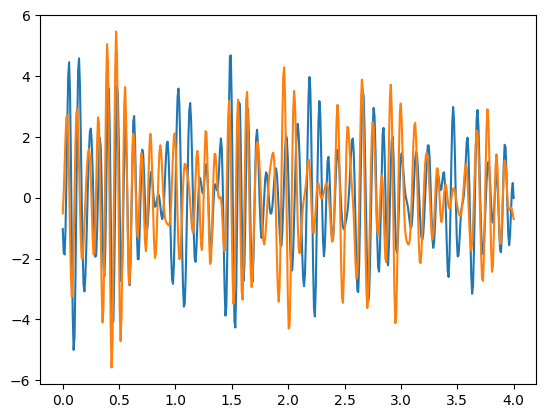

In [196]:
plt.plot(times, x_augm[0][0])
plt.plot(times, TS)
plt.show()

In [10]:
 mne.set_config('MNE_BROWSE_RAW_SIZE','18,11')

In [11]:
print(mne.get_config(key=''))

('MNE_3D_OPTION_ANTIALIAS', 'MNE_3D_OPTION_DEPTH_PEELING', 'MNE_3D_OPTION_MULTI_SAMPLES', 'MNE_3D_OPTION_SMOOTH_SHADING', 'MNE_3D_OPTION_THEME', 'MNE_BROWSE_RAW_SIZE', 'MNE_BROWSER_BACKEND', 'MNE_BROWSER_OVERVIEW_MODE', 'MNE_BROWSER_PRECOMPUTE', 'MNE_BROWSER_THEME', 'MNE_BROWSER_USE_OPENGL', 'MNE_CACHE_DIR', 'MNE_COREG_ADVANCED_RENDERING', 'MNE_COREG_COPY_ANNOT', 'MNE_COREG_FULLSCREEN', 'MNE_COREG_GUESS_MRI_SUBJECT', 'MNE_COREG_HEAD_HIGH_RES', 'MNE_COREG_HEAD_OPACITY', 'MNE_COREG_HEAD_INSIDE', 'MNE_COREG_INTERACTION', 'MNE_COREG_MARK_INSIDE', 'MNE_COREG_PREPARE_BEM', 'MNE_COREG_ORIENT_TO_SURFACE', 'MNE_COREG_SCALE_LABELS', 'MNE_COREG_SCALE_BY_DISTANCE', 'MNE_COREG_SCENE_SCALE', 'MNE_COREG_WINDOW_HEIGHT', 'MNE_COREG_WINDOW_WIDTH', 'MNE_COREG_SUBJECTS_DIR', 'MNE_CUDA_DEVICE', 'MNE_CUDA_IGNORE_PRECISION', 'MNE_DATA', 'MNE_DATASETS_BRAINSTORM_PATH', 'MNE_DATASETS_EEGBCI_PATH', 'MNE_DATASETS_EPILEPSY_ECOG_PATH', 'MNE_DATASETS_HF_SEF_PATH', 'MNE_DATASETS_MEGSIM_PATH', 'MNE_DATASETS_MISC_PATH

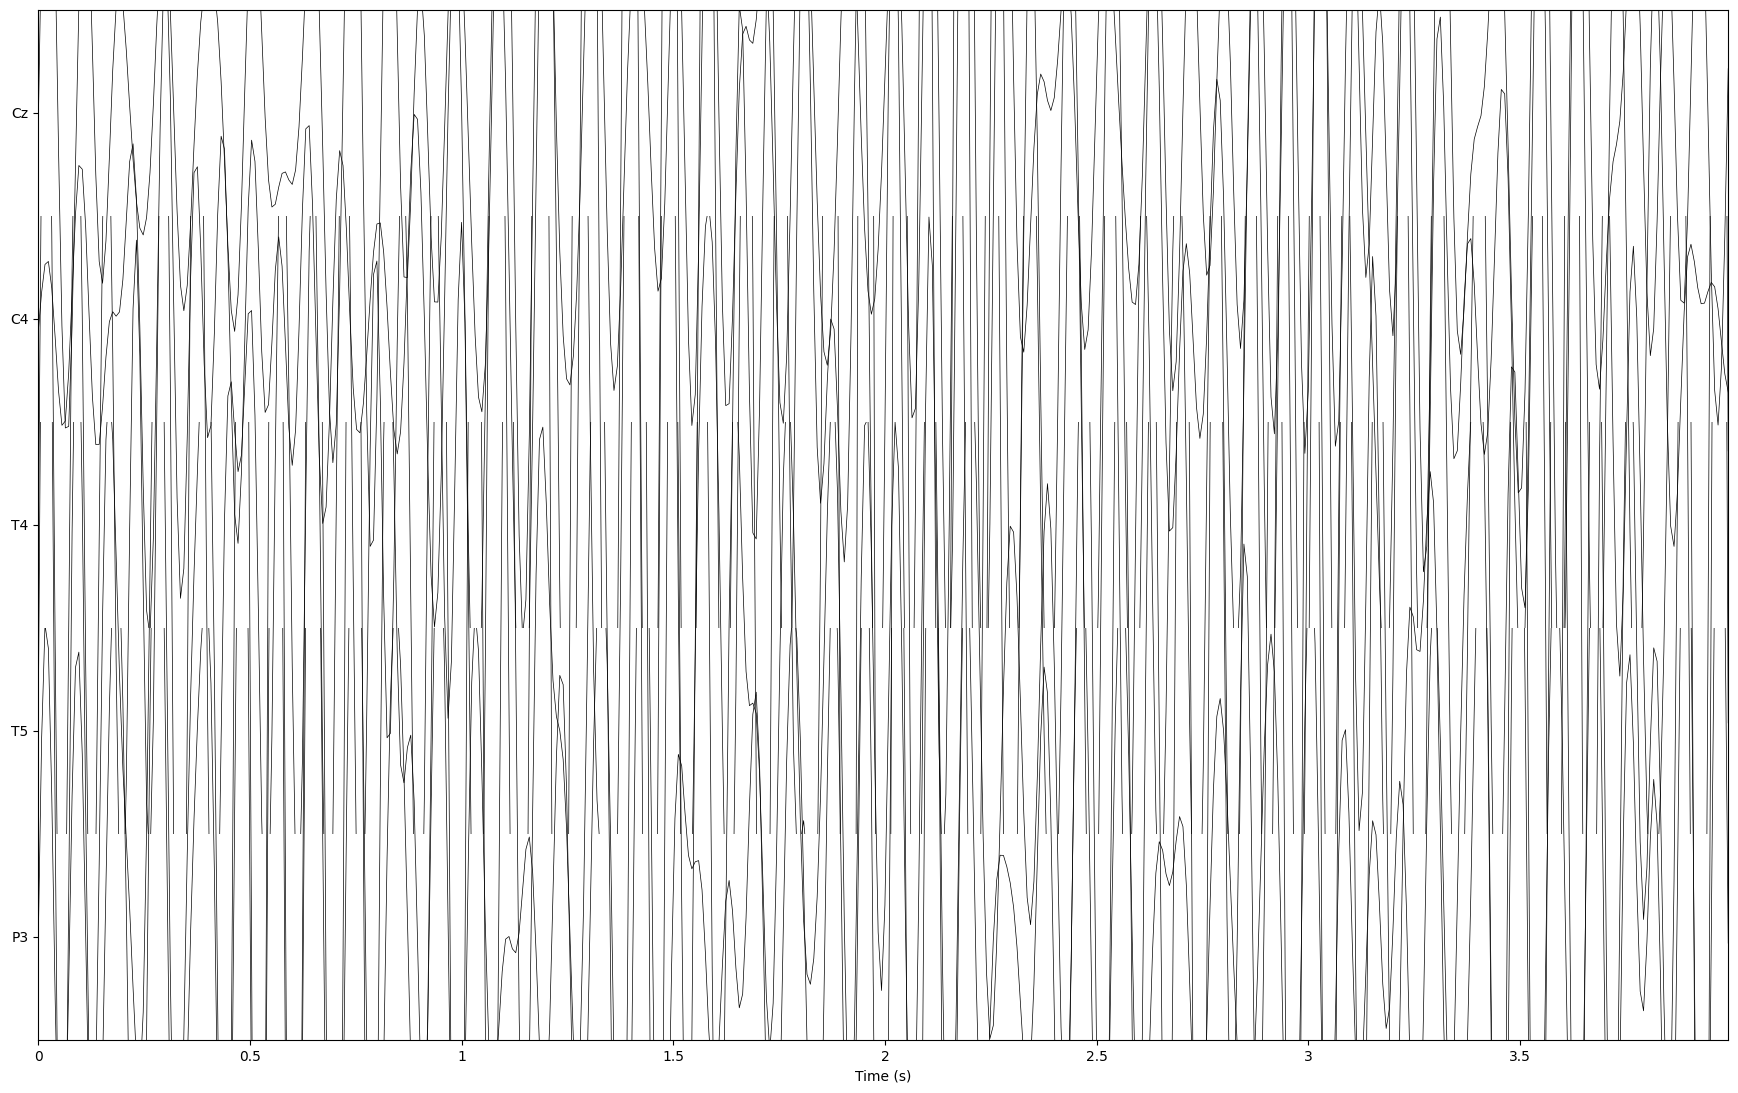

In [455]:
trial_raw.plot(scalings='auto',duration=4,n_channels=5,show_scrollbars=False, show_scalebars=False, proj=False)
plt.show()

In [456]:
trial_psd = trial_raw.compute_psd('welch',0, 20)
psds, freqs = trial_psd.get_data(return_freqs=True)
print(f'\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}')

Effective window size : 2.048 (s)

PSDs shape: (16, 41), freqs shape: (41,)


C:\Users\annag\anaconda3\envs\BCI\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


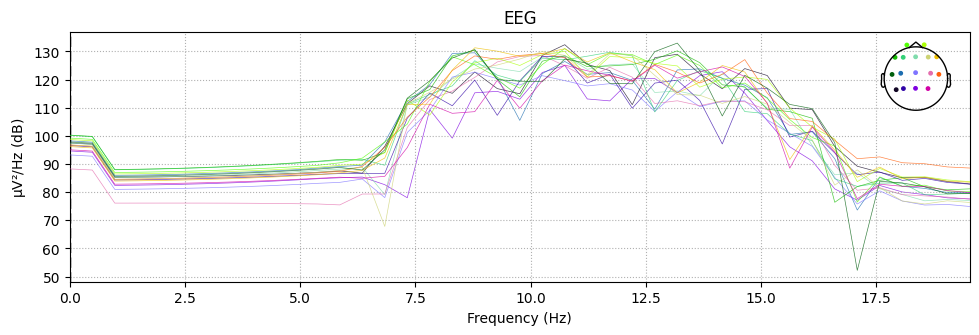

In [457]:
trial_psd.plot()
plt.show()

# Create MNE array

In [458]:
# Get epochs of label right
idx_right = np.where(y_train=='R')[0]
idx_left = np.where(y_train=='L')[0]

data_epochs_right = x_train[idx_right]
data_epochs_left = x_train[idx_left]

In [459]:
print(np.shape(data_epochs_left))

(48, 16, 500)


In [460]:
# Take 1.5 seconds
data_epochs_right_15 = data_epochs_right[:,:,100:200]
data_epochs_left_15 = data_epochs_left[:,:,100:200]
data_epochs_right_30 = data_epochs_right[:,:,100:600]
data_epochs_left_30 = data_epochs_left[:,:,100:600]

In [461]:
epochs_right_15 = mne.EpochsArray(data_epochs_right_15, info)
epochs_left_15 = mne.EpochsArray(data_epochs_left_15, info)
epochs_right_30 = mne.EpochsArray(data_epochs_right_30, info)
epochs_left_30 = mne.EpochsArray(data_epochs_left_30, info)

Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated


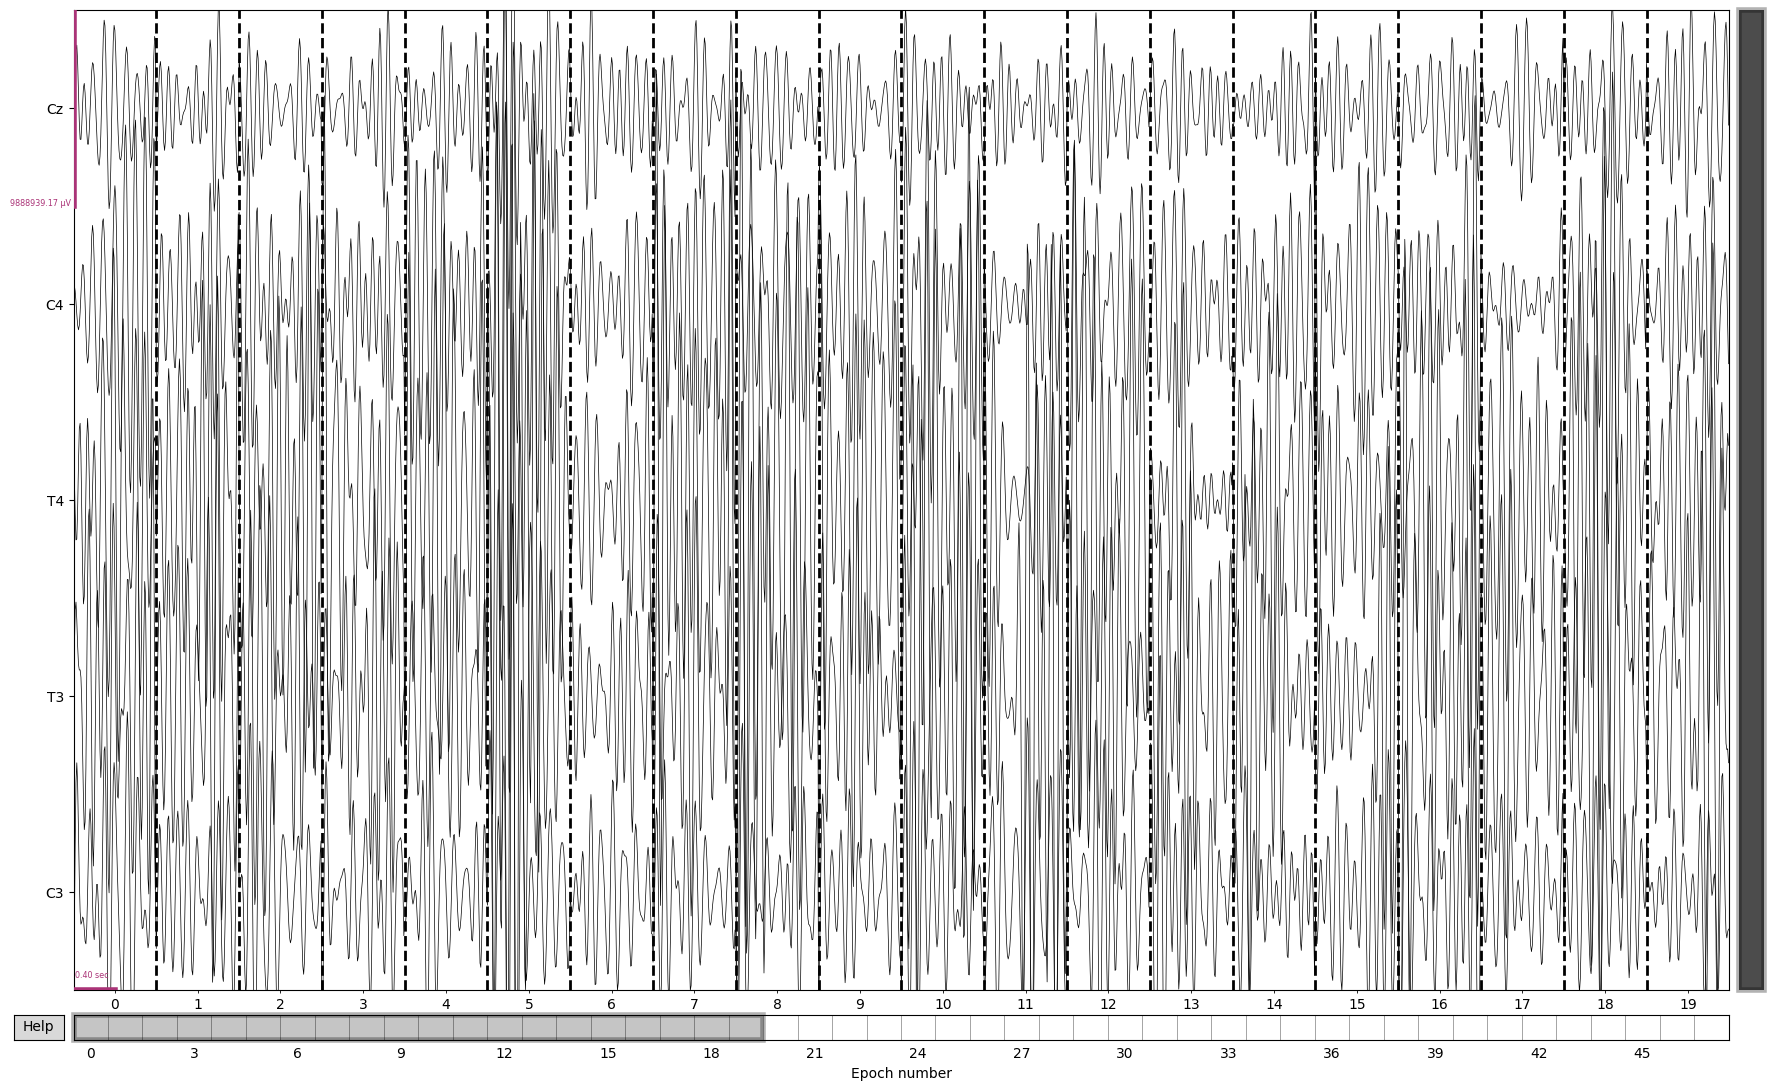

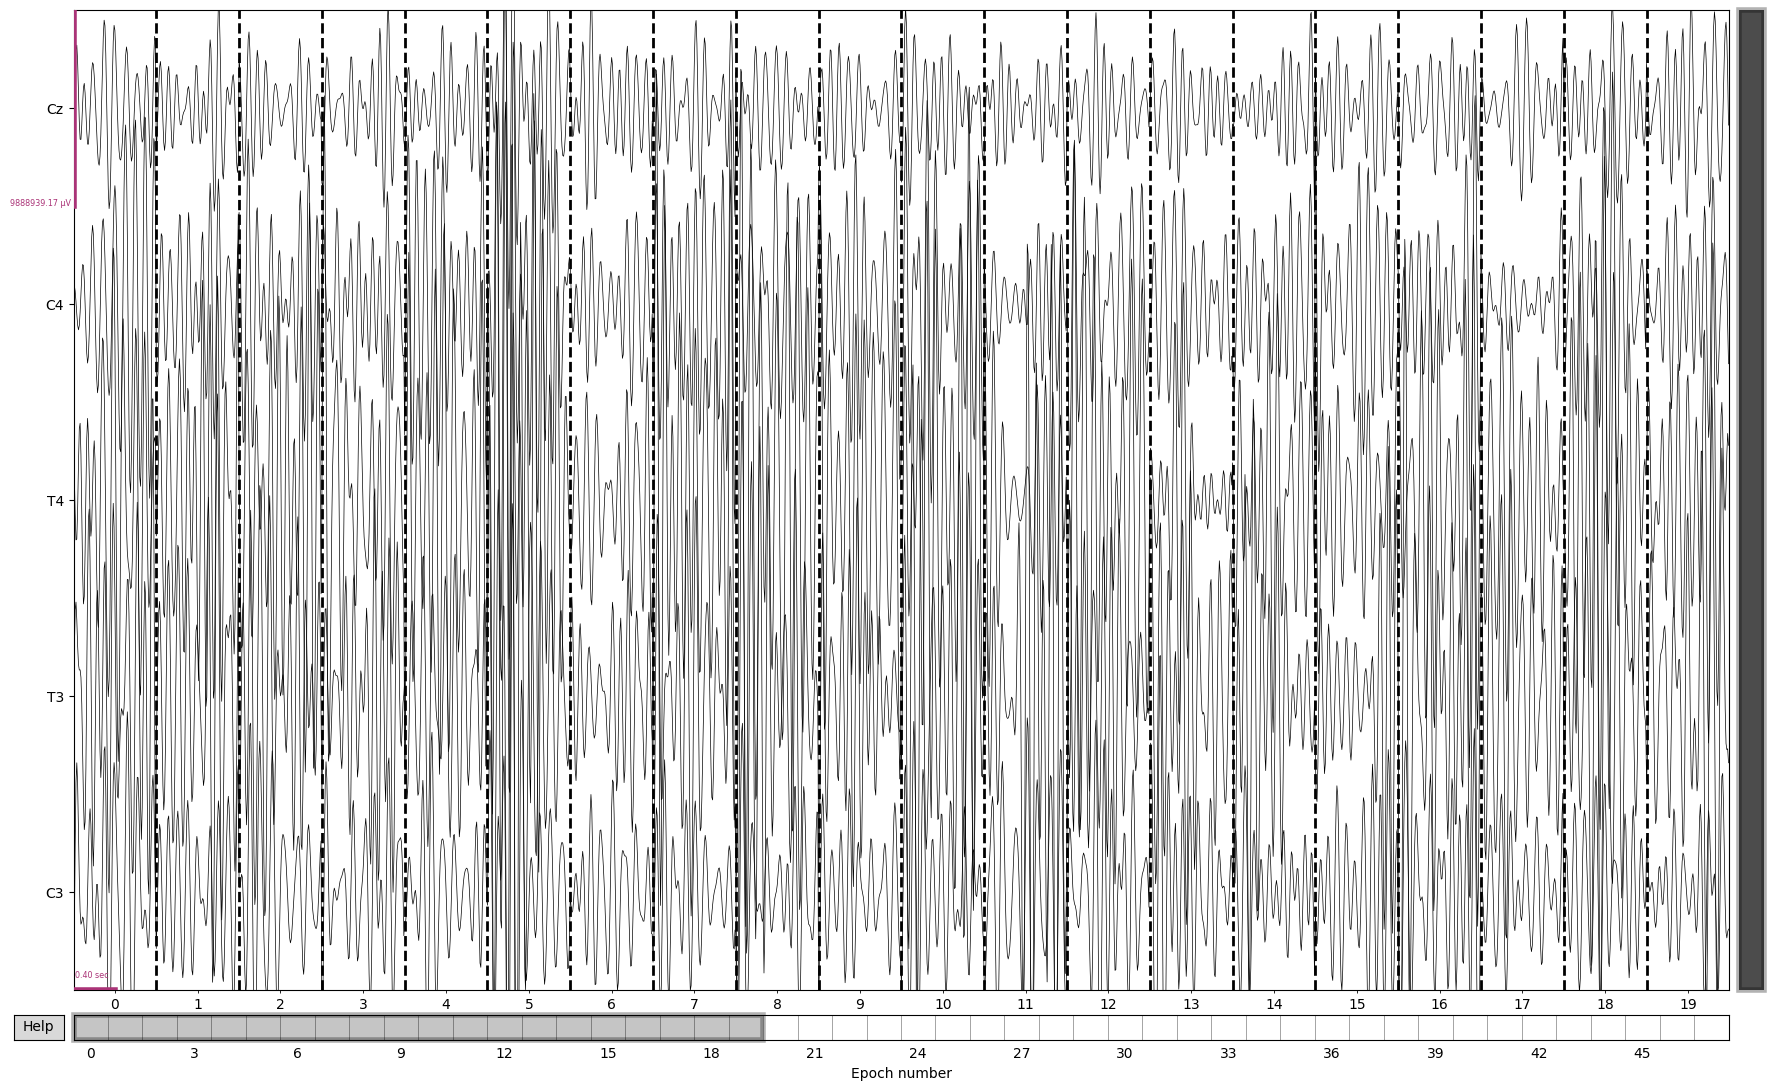

In [462]:
epochs_right_15.plot(scalings="auto",picks=['Cz','C4','T4','C3','T3'])

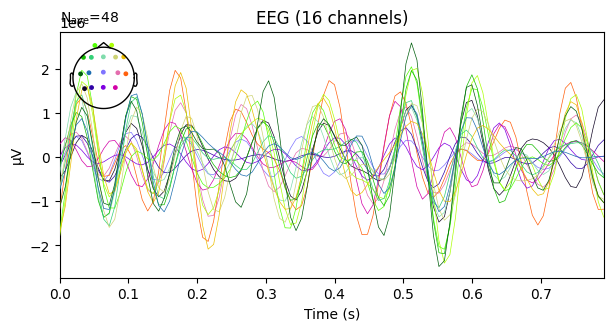

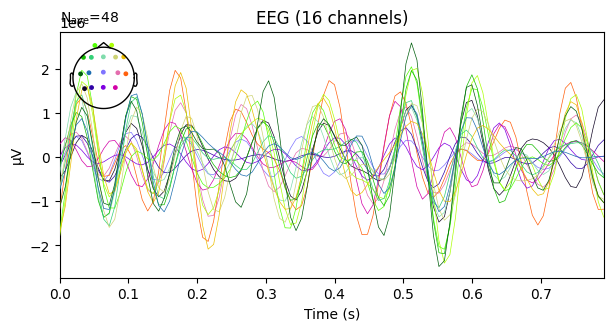

In [463]:
epochs_right_15.average().plot()

In [464]:
avg_trials = np.mean(data_epochs_right_15)
print(avg_trials)

0.011146415091452953


# Right average plots

In [465]:
average_values = np.mean(data_epochs_right, axis=0)
min_val = np.min(average_values)*1000000
print(min_val)
max_val = np.max(average_values)*1000000
print(max_val)

-3038510.760262161
3011557.5160734463


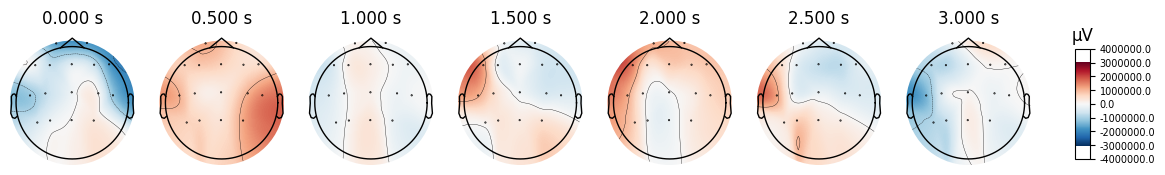

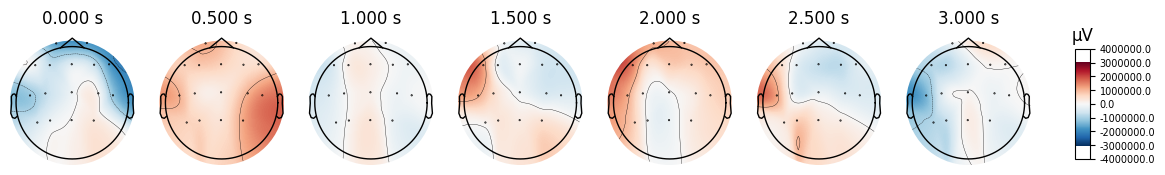

In [466]:
#epochs_right_30.average().plot_topomap(times=[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],vlim=[470000, 530000])
epochs_right_30.average().plot_topomap(times=[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],vlim=[min_val, max_val])

# Left average plots

In [467]:
average_values = np.mean(data_epochs_left, axis=0)
min_val = np.min(average_values)*1000000
print(min_val)
max_val = np.max(average_values)*1000000
print(max_val)

-2459799.7297359165
2341830.672710006


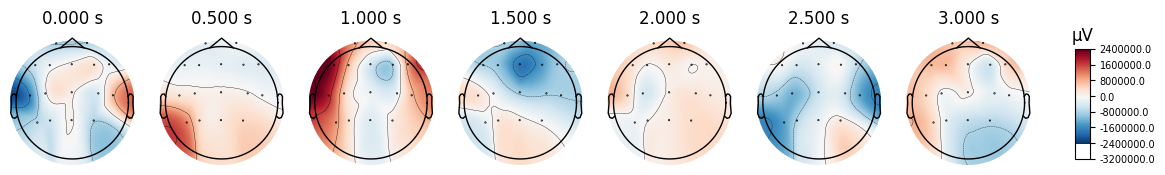

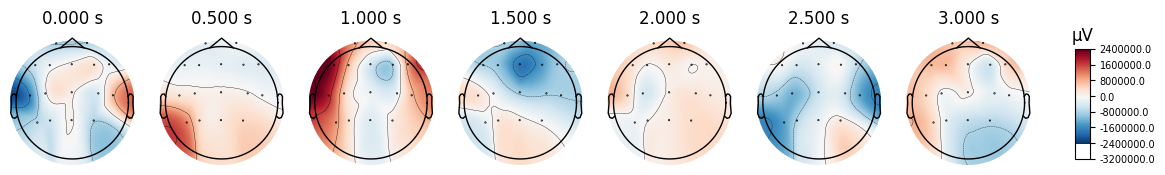

In [468]:
epochs_left_30.average().plot_topomap(times=[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],vlim=[min_val, max_val])

In [469]:
avg_epoch = epochs.average().data

In [402]:
np.shape(avg_epoch)

(16, 100)

In [403]:
epochs.average()

<Evoked | '1' (average, N=96), 0 – 0.792 sec, baseline off, 16 ch, ~41 kB>

In [404]:
average_values = np.mean(data_epochs_right, axis=0)

In [405]:
np.min(average_values)

-3.6988097612824133

In [406]:
np.max(average_values)

3.6589730804324523

# Channel pairs

In [310]:
#Params
data_root = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/data/raw/"
#channels = [["C3","C4"],["F3","F4"],["P3","P4"]]
channels = [["C3","C4"],["F3","F4"],["P3","P4"],["FP1","FP2"],["F7","F8"],["T3","T4"]]
# Select subject for visualization
sub =  ["dani"]
# test_subjects = ["dani", "ivo", "pablo", "huiyu", "manu", "fabio", "anna", "luisa", "sarah", "irene", "jan"]
measurements = []


# Get dataset
trainingset = BCIDataset(data_root, sub, [], measurement_length=4)
trainingset.validate_data()
trainingset.apply_bandpass_filtering(selected_data="sample")

#Load data
x, y, ch_pairs = trainingset.load_subject_data(sub[0], channels)
indexes = range(0,len(x))

#Reshape for scaling
reshaped_x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

# Train test split
train_idx, test_idx, y_train_raw, y_test = train_test_split(indexes,
                                                            y,
                                                            stratify=y,
                                                            test_size=0.20,
                                                            random_state=42)
x_train_raw = reshaped_x[train_idx]
x_test_raw = reshaped_x[test_idx]
y_train_raw = y[train_idx]
y_test = y[test_idx]
ch_pairs_train = ch_pairs[train_idx]
ch_pairs_test = ch_pairs[test_idx]

#Scale indipendently train/test
#Axis used to scale along. If 0, independently scale each feature, otherwise (if 1) scale each sample.
# x_train_scaled_raw = minmax_scale(x_train_raw, axis=1)
# x_test_scaled_raw = minmax_scale(x_test_raw, axis=1)
x_train_scaled_raw = x_train_raw
x_test_scaled_raw = x_test_raw

x_test = x_test_scaled_raw.reshape(x_test_scaled_raw.shape[0], x.shape[1], x.shape[2]).astype(np.float64)

x_train = x_train_scaled_raw.reshape(x_train_scaled_raw.shape[0], x.shape[1], x.shape[2]).astype(np.float64)
y_train = y_train_raw

Subjects: ['dani']
Total invalid samples: 0
Get data from subjects: ['dani']


In [311]:
# Get trials of selected channel pairs
ch_pair_data = {}
for ch in channels:
    ch_pair_name = ' '.join(ch)
    ch_pair_data[ch_pair_name] = {'L':np.array([]), 'R':np.array([])}
    # Iterate over all trials
    for i in range(len(ch_pairs_train)):
        pair = list(ch_pairs_train[i])
        if pair == ch:
            # Get label
            label = y_train[i]
            data = np.expand_dims(x_train[i], axis=0)

            if label == 'L':
                if len(ch_pair_data[ch_pair_name]['L']) > 0:
                    ch_pair_data[ch_pair_name]['L'] = np.concatenate((ch_pair_data[ch_pair_name]['L'], data), axis=0)
                else:
                    ch_pair_data[ch_pair_name]['L'] = data
            elif label == 'R':
                if len(ch_pair_data[ch_pair_name]['R']) > 0:
                    ch_pair_data[ch_pair_name]['R'] = np.concatenate((ch_pair_data[ch_pair_name]['R'], data), axis=0)
                else:
                    ch_pair_data[ch_pair_name]['R'] = data
            else:
                print("Label doesn't exist.")

In [312]:
print(np.shape(ch_pair_data['C3 C4']['L']))
print(np.shape(ch_pair_data['C3 C4']['R']))

(47, 2, 500)
(49, 2, 500)


### Create epochs data

In [313]:
ch_pair_names = list(ch_pair_data.keys())
print(ch_pair_names)

['C3 C4', 'F3 F4', 'P3 P4', 'FP1 FP2', 'F7 F8', 'T3 T4']


In [314]:
sampling_freq = trainingset.sample_rate
ch_types = ['eeg'] * 2

ch_pair_psd = {}
ch_pair_epochs = {}
for i in range(len(ch_pair_names)):
    # Create Info
    pair_name = ch_pair_names[i]
    ch_pair = channels[i]
    if ch_pair == ['FP1', 'FP2']:
        ch_pair = ['Fp1', 'Fp2']
    info = mne.create_info(ch_pair, ch_types=ch_types, sfreq=sampling_freq)
    info.set_montage('standard_1020')
    info['description'] = 'Data of channel pair '+ pair_name
    
    # Create epoch
    data_left = ch_pair_data[pair_name]['L']
    data_right = ch_pair_data[pair_name]['R']
    epochs_left = mne.EpochsArray(data_left, info)
    epochs_right = mne.EpochsArray(data_right, info)
    
    # Calc Psd
    psd_left = epochs_left.average().compute_psd('welch',0, 20)
    psd_right = epochs_right.average().compute_psd('welch',0, 20)
    
    ch_pair_psd[pair_name] = {'L': psd_left, 'R': psd_right}
    ch_pair_epochs[pair_name] = {'L': epochs_left, 'R': epochs_right}

Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Not setting metadata
51 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
51 matching events found
No basel

C:\Users\annag\anaconda3\envs\BCI\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


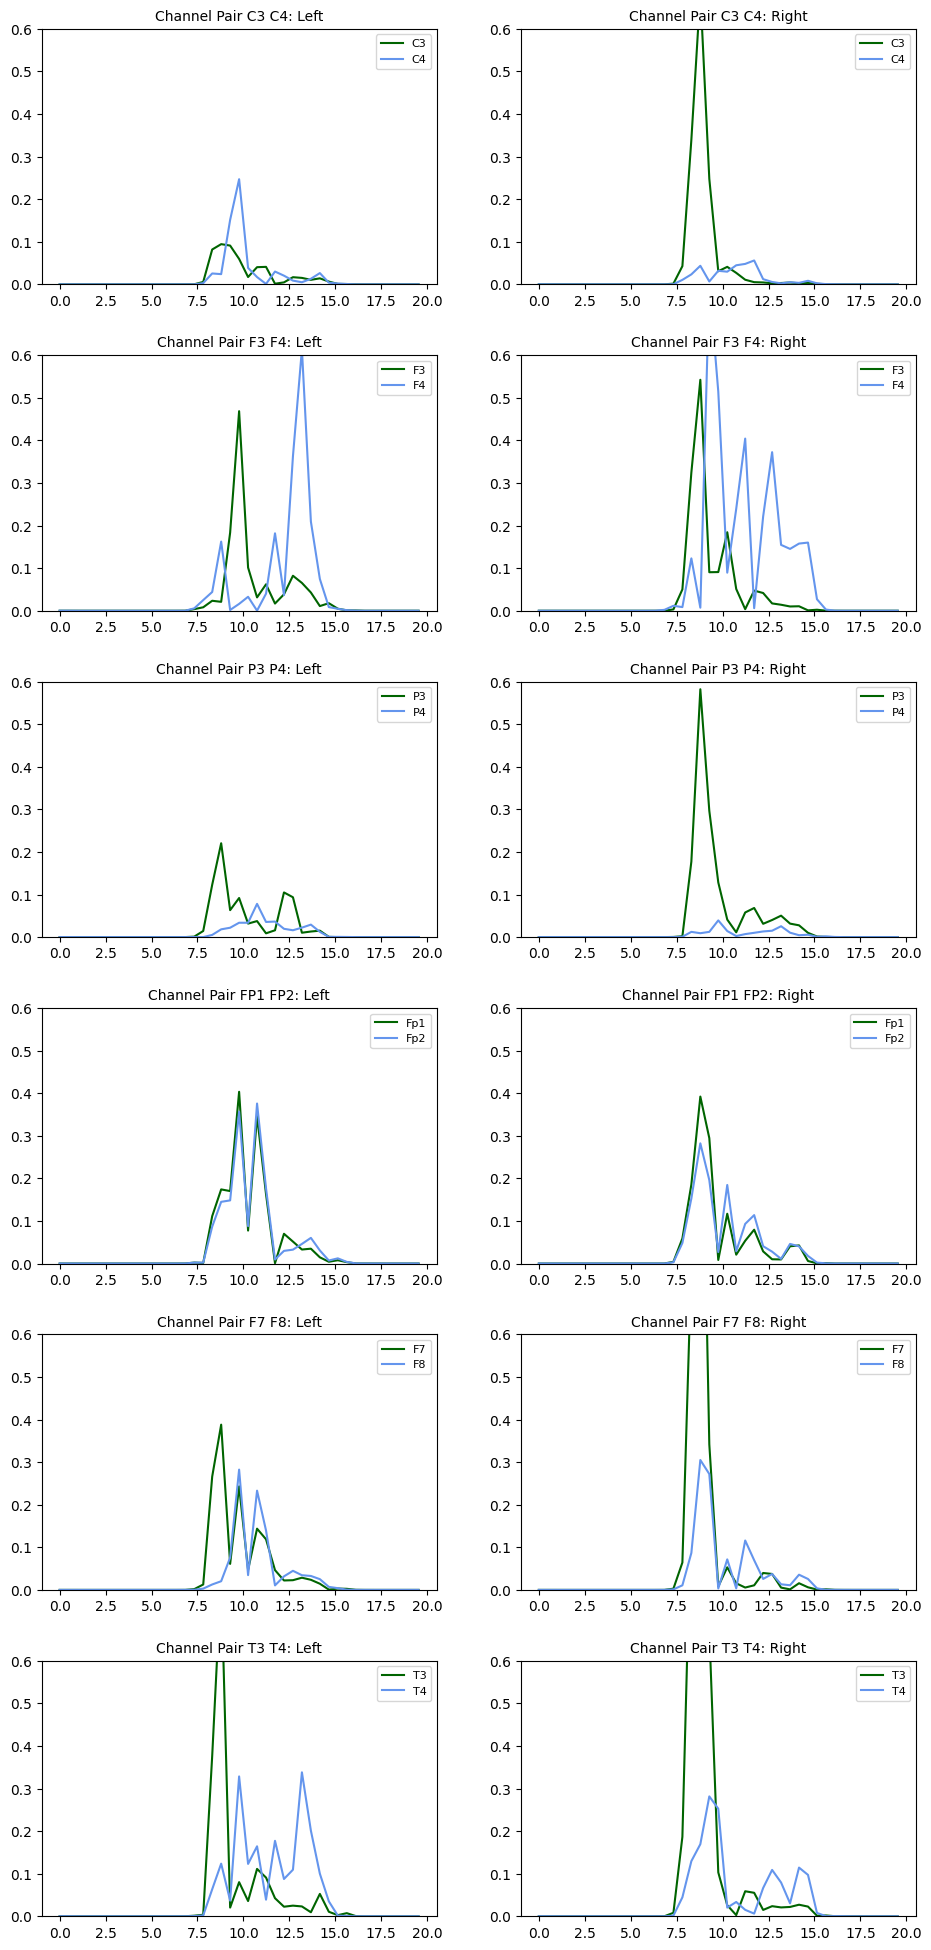

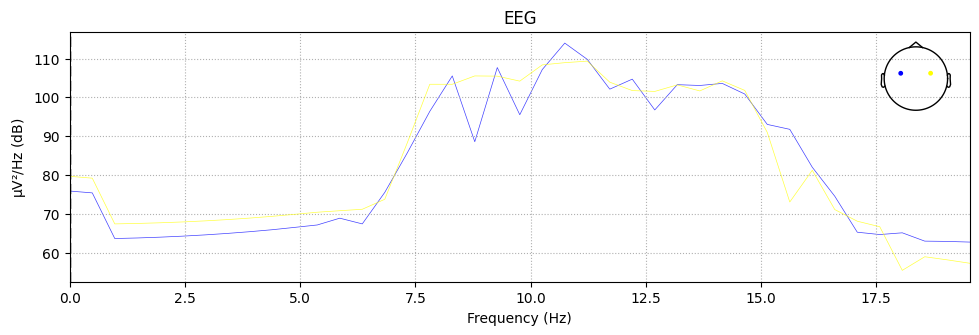

In [315]:
ch_pair_psd['C3 C4']['L'].plot()
plt.show()

In [316]:
from mpl_toolkits.axes_grid1 import (make_axes_locatable, ImageGrid,
                                     inset_locator)

In [317]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10,20))
fig.tight_layout(pad=3.0)

y_lim = 0.6

# C3 C4
psds, freqs = ch_pair_psd[ch_pair_names[0]]['L'].get_data(return_freqs=True)
axes[0,0].plot(freqs, psds[0], label="C3", c="darkgreen")
axes[0,0].plot(freqs, psds[1], label="C4", c="cornflowerblue")
axes[0,0].set_title("Channel Pair " + ch_pair_names[0]+": Left", fontsize=10)
axes[0,0].legend(fontsize=8)
axes[0,0].set_ylim(0,y_lim)

# axins = inset_locator.inset_axes(axes[0,0], width="40%", height="40%", loc=2)
# ch_pair_epochs[ch_pair_names[0]]['L'].copy().plot_sensors(title="", show_names=True, axes=axins)
# sensor_dots = axins.collections[0]
# sensor_dots.set_sizes([1])

psds, freqs = ch_pair_psd[ch_pair_names[0]]['R'].get_data(return_freqs=True)
axes[0,1].plot(freqs, psds[0], label="C3", c="darkgreen")
axes[0,1].plot(freqs, psds[1], label="C4", c="cornflowerblue")
axes[0,1].set_title("Channel Pair " + ch_pair_names[0]+": Right", fontsize=10)
axes[0,1].legend(fontsize=8)
axes[0,1].set_ylim(0,y_lim)


# F3 F4
psds, freqs = ch_pair_psd[ch_pair_names[1]]['L'].get_data(return_freqs=True)
axes[1,0].plot(freqs, psds[0], label="F3", c="darkgreen")
axes[1,0].plot(freqs, psds[1], label="F4", c="cornflowerblue")
axes[1,0].set_title("Channel Pair " + ch_pair_names[1]+": Left", fontsize=10)
axes[1,0].legend(fontsize=8)
axes[1,0].set_ylim(0,y_lim)


psds, freqs = ch_pair_psd[ch_pair_names[1]]['R'].get_data(return_freqs=True)
axes[1,1].plot(freqs, psds[0], label="F3", c="darkgreen")
axes[1,1].plot(freqs, psds[1], label="F4", c="cornflowerblue")
axes[1,1].set_title("Channel Pair " + ch_pair_names[1]+": Right", fontsize=10)
axes[1,1].legend(fontsize=8)
axes[1,1].set_ylim(0,y_lim)

# P3 P4
psds, freqs = ch_pair_psd[ch_pair_names[2]]['L'].get_data(return_freqs=True)
axes[2,0].plot(freqs, psds[0], label="P3", c="darkgreen")
axes[2,0].plot(freqs, psds[1], label="P4", c="cornflowerblue")
axes[2,0].set_title("Channel Pair " + ch_pair_names[2]+": Left", fontsize=10)
axes[2,0].legend(fontsize=8)
axes[2,0].set_ylim(0,y_lim)

psds, freqs = ch_pair_psd[ch_pair_names[2]]['R'].get_data(return_freqs=True)
axes[2,1].plot(freqs, psds[0], label="P3", c="darkgreen")
axes[2,1].plot(freqs, psds[1], label="P4", c="cornflowerblue")
axes[2,1].set_title("Channel Pair " + ch_pair_names[2]+": Right", fontsize=10)
axes[2,1].legend(fontsize=8)
axes[2,1].set_ylim(0,y_lim)

# Fp1 Fp2
psds, freqs = ch_pair_psd[ch_pair_names[3]]['L'].get_data(return_freqs=True)
axes[3,0].plot(freqs, psds[0], label="Fp1", c="darkgreen")
axes[3,0].plot(freqs, psds[1], label="Fp2", c="cornflowerblue")
axes[3,0].set_title("Channel Pair " + ch_pair_names[3]+": Left", fontsize=10)
axes[3,0].legend(fontsize=8)
axes[3,0].set_ylim(0,y_lim)

psds, freqs = ch_pair_psd[ch_pair_names[3]]['R'].get_data(return_freqs=True)
axes[3,1].plot(freqs, psds[0], label="Fp1", c="darkgreen")
axes[3,1].plot(freqs, psds[1], label="Fp2", c="cornflowerblue")
axes[3,1].set_title("Channel Pair " + ch_pair_names[3]+": Right", fontsize=10)
axes[3,1].legend(fontsize=8)
axes[3,1].set_ylim(0,y_lim)

# F7 F8
psds, freqs = ch_pair_psd[ch_pair_names[4]]['L'].get_data(return_freqs=True)
axes[4,0].plot(freqs, psds[0], label="F7", c="darkgreen")
axes[4,0].plot(freqs, psds[1], label="F8", c="cornflowerblue")
axes[4,0].set_title("Channel Pair " + ch_pair_names[4]+": Left", fontsize=10)
axes[4,0].legend(fontsize=8)
axes[4,0].set_ylim(0,y_lim)

psds, freqs = ch_pair_psd[ch_pair_names[4]]['R'].get_data(return_freqs=True)
axes[4,1].plot(freqs, psds[0], label="F7", c="darkgreen")
axes[4,1].plot(freqs, psds[1], label="F8", c="cornflowerblue")
axes[4,1].set_title("Channel Pair " + ch_pair_names[4]+": Right", fontsize=10)
axes[4,1].legend(fontsize=8)
axes[4,1].set_ylim(0,y_lim)

# T3 T4
psds, freqs = ch_pair_psd[ch_pair_names[5]]['L'].get_data(return_freqs=True)
axes[5,0].plot(freqs, psds[0], label="T3", c="darkgreen")
axes[5,0].plot(freqs, psds[1], label="T4", c="cornflowerblue")
axes[5,0].set_title("Channel Pair " + ch_pair_names[5]+": Left", fontsize=10)
axes[5,0].legend(fontsize=8)
axes[5,0].set_ylim(0,y_lim)

psds, freqs = ch_pair_psd[ch_pair_names[5]]['R'].get_data(return_freqs=True)
axes[5,1].plot(freqs, psds[0], label="T3", c="darkgreen")
axes[5,1].plot(freqs, psds[1], label="T4", c="cornflowerblue")
axes[5,1].set_title("Channel Pair " + ch_pair_names[5]+": Right", fontsize=10)
axes[5,1].legend(fontsize=8)
axes[5,1].set_ylim(0,y_lim)

#plt.show()

(0.0, 0.6)

In [3]:
print((0.96+0.95+0.67+0.97+0.97+0.93)/6)
print((0.91+0.77+0.70+0.91+0.92+0.88)/6)
print((0.99+0.74+0.91+0.99+1.0+1.0)/6)
print((0.98+0.63+0.86+0.95+0.97+0.97)/6)
print((1.0+0.46+0.79+0.95+0.97+0.93)/6)
print((0.97+0.99+0.53+0.99+0.99+0.97)/6)
print((1.0+1.0+0.9+1.0+1.0+1.0)/6)
print((1.0+0.99+1.0+1.0+0.99+1.0)/6)
print((0.98+1.0+0.92+1.0+0.99+0.91)/6)
print((0.82+0.91+0.60+0.74+0.91+0.91)/6)
print((0.87+0.96+0.49+0.92+0.95+0.80)/6)

0.9083333333333332
0.8483333333333333
0.9383333333333334
0.8933333333333332
0.85
0.9066666666666667
0.9833333333333334
0.9966666666666667
0.9666666666666667
0.8150000000000001
0.8316666666666667


In [318]:
output_folder = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/reports/figures/"
plt.savefig(output_folder+'ch_pairs_psd_'+sub[0]+'.png', bbox_inches='tight')

# Training curve

In [471]:
import pickle

## Good results

In [489]:
history_path = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/models/1D_CNN/\ours_3_pairs/fine_tuned/mydataset_base/sub_luisa/hist_finetuned_sub_luisa_2023-04-12_19-55-42.pkl"
with open(history_path, 'rb') as file:
    history = pickle.load(file)

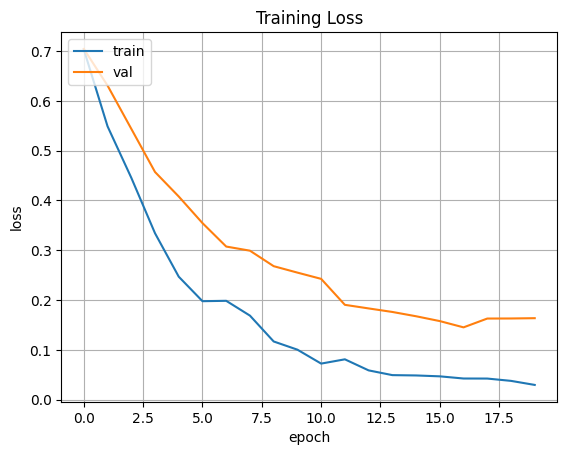

In [490]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

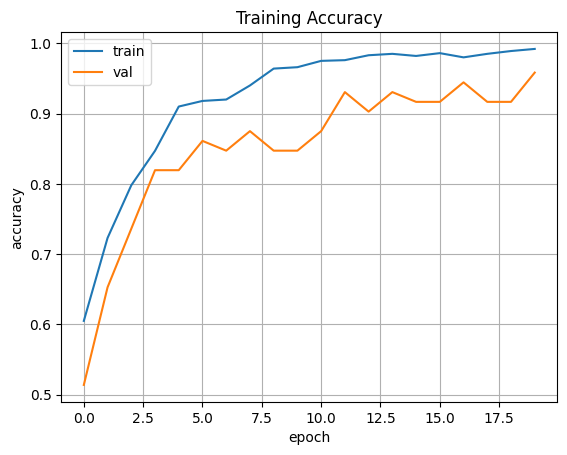

In [491]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

## Bad results

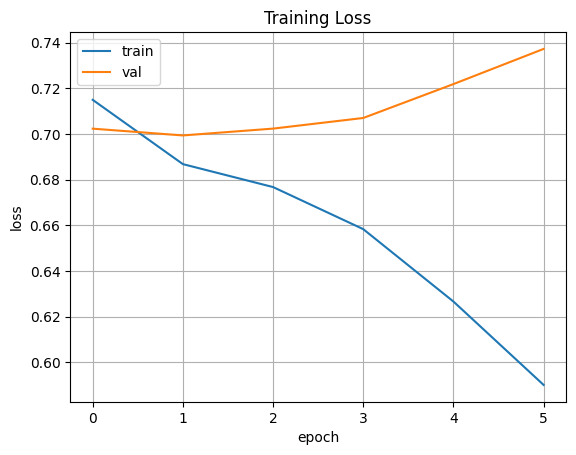

In [485]:
history_path = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/models/1D_CNN/ours_3_pairs/fine_tuned/mydataset_base/sub_irene/hist_finetuned_sub_irene_2023-04-12_19-55-42.pkl"
with open(history_path, 'rb') as file:
    history = pickle.load(file)
    
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

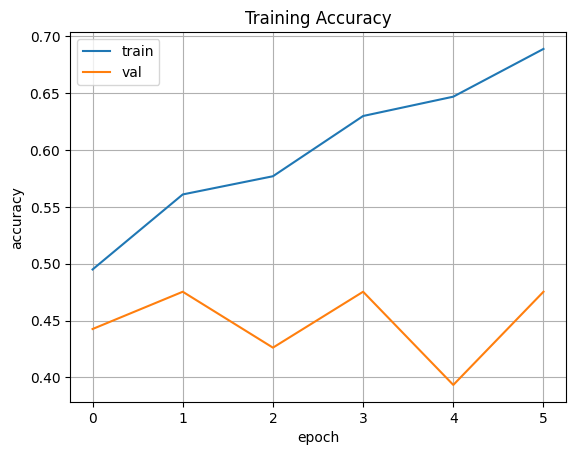

In [487]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [344]:
path = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/models/1D_CNN/ours_3_pairs/fine_tuned/physionet_base/sub_34/fold_0/confusion_matrix_2023-04-25_15-06-56.pkl"

In [345]:
with open(path, 'rb') as file:
    cm = pickle.load(file)

In [346]:
print(cm)

{'TN': 10, 'FP': 3, 'FN': 2, 'TP': 12}
